In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio

pd.options.plotting.backend = "plotly"
pio.templates.default = "plotly_white"


import json
import requests
import pickle



In [17]:
df = pd.read_csv("https://raw.githubusercontent.com/guebin/DV2023/main/posts/NYCTaxi.csv").assign(
    log_trip_duration = lambda df: np.log(df.trip_duration),
    pickup_datetime = lambda df: df.pickup_datetime.apply(pd.to_datetime),
    dropoff_datetime = lambda df: df.dropoff_datetime.apply(pd.to_datetime),
    dist = lambda df: np.sqrt((df.pickup_latitude-df.dropoff_latitude)**2 + (df.pickup_longitude-df.dropoff_longitude)**2),
    #---#
    vendor_id = lambda df: df.vendor_id.map({1:'A',2:'B'})
).assign(
    speed = lambda df: df.dist / df.trip_duration,
    pickup_hour = lambda df: df.pickup_datetime.dt.hour,
    dropoff_hour = lambda df: df.dropoff_datetime.dt.hour,
    dayofweek = lambda df: df.pickup_datetime.dt.dayofweek
)
df_small = df[::100].reset_index(drop=True)

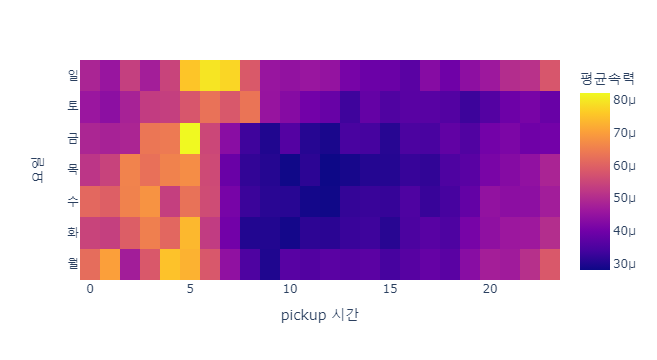

In [18]:
tidydata = df.pivot_table(
    index='pickup_hour',
    columns='dayofweek',
    values='speed',
    aggfunc= 'mean'
    ).stack().reset_index().rename({0:'speed_mean'},axis=1)\
.set_index(['pickup_hour','speed_mean']).apply(lambda x: x.replace({0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'})).reset_index()
px.density_heatmap(
    data_frame=tidydata,
    x='pickup_hour',
    y='dayofweek',
    z='speed_mean',
    nbinsx=24,
    nbinsy=7,
    height=450
).update_layout(coloraxis_colorbar=dict(
    title="평균속력"),xaxis=dict(title='pickup 시간'),yaxis=dict(title='요일'))

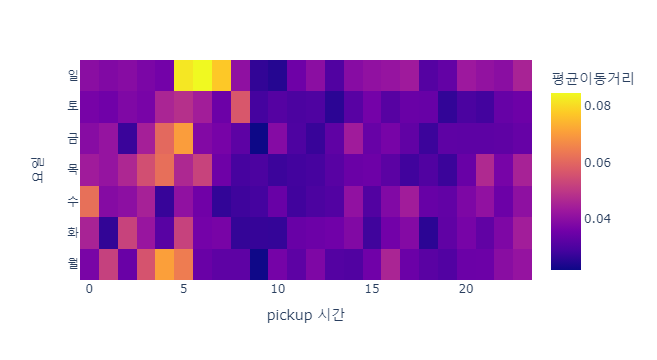

In [19]:
tidydata = df.pivot_table(
    index = 'pickup_hour',
    columns = 'dayofweek',
    values = 'dist',
    aggfunc = 'mean'
).stack().reset_index().rename({0:'dist_mean'},axis=1)\
.set_index(['pickup_hour','dist_mean']).apply(lambda x: x.replace({0:'월',1:'화',2:'수',3:'목',4:'금',5:'토',6:'일'})).reset_index()
px.density_heatmap(
    data_frame=tidydata,
    x='pickup_hour',
    y='dayofweek',
    z='dist_mean',
    nbinsx=24,
    nbinsy=7,
    height=450
).update_layout(coloraxis_colorbar=dict(
    title="평균이동거리"),xaxis=dict(title='pickup 시간'),yaxis=dict(title='요일'))

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



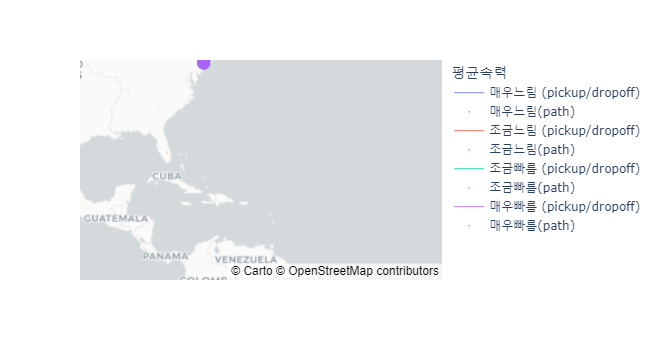

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/root/anaconda3/envs/dv2023/lib/python3.10/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



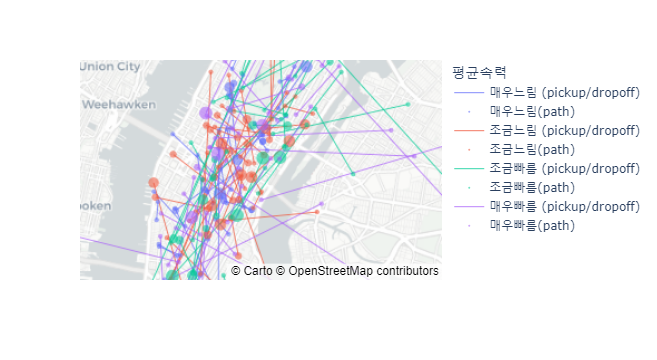

In [21]:

# 평균속력을 4개의 범주로 나누고 데이터를 속도 순으로 정렬
smalldf = df_small.assign(
    평균속력=pd.qcut(df_small.speed, 4, labels=['매우느림', '조금느림', '조금빠름', '매우빠름'])
).sort_values('speed', ascending=True)

# 픽업과 드롭오프 관련 열
pcol = ['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'pickup_hour']
dcol = ['dropoff_datetime', 'dropoff_longitude', 'dropoff_latitude', 'dropoff_hour']

# 데이터 변환 함수
def transform(smalldf):
    pickup = smalldf.loc[:, ['id'] + pcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'], axis=1).assign(type='pickup')
    dropoff = smalldf.loc[:, ['id'] + dcol].set_axis(['id', 'datetime', 'longitude', 'latitude', 'hour'], axis=1).assign(type='dropoff')
    return pd.concat([pickup, dropoff], axis=0)

# 데이터 변환과 병합
df_left = smalldf.drop(pcol + dcol, axis=1)
df_right = pd.concat([transform(df) for i, df in smalldf.groupby('id')]).reset_index(drop=True)
smalldf2 = df_left.merge(df_right, on='id')

# 시각화 데이터 준비
tidydata = smalldf2

# 선형 지도 시각화
fig3 = px.line_mapbox(
    data_frame=tidydata,
    lat='latitude',
    lon='longitude',
    color='평균속력',
    line_group='id',
    mapbox_style='carto-positron',
    zoom=11
)

# 범례 이름 변경
fig3.for_each_trace(lambda t: t.update(name=t.name.replace('매우빠름', '매우빠름 (pickup/dropoff)')))
fig3.for_each_trace(lambda t: t.update(name=t.name.replace('조금빠름', '조금빠름 (pickup/dropoff)')))
fig3.for_each_trace(lambda t: t.update(name=t.name.replace('조금느림', '조금느림 (pickup/dropoff)')))
fig3.for_each_trace(lambda t: t.update(name=t.name.replace('매우느림', '매우느림 (pickup/dropoff)')))

# 산점도 데이터
scatter_data = px.scatter_mapbox(
    data_frame=tidydata,
    lat='latitude',
    lon='longitude',
    color='평균속력',
    size='passenger_count',
    size_max=10,
    mapbox_style='carto-positron',
    zoom=11
).for_each_trace(lambda t: t.update(name=t.name.replace('매우빠름', '매우빠름(path)')))\
.for_each_trace(lambda t: t.update(name=t.name.replace('조금빠름', '조금빠름(path)')))\
.for_each_trace(lambda t: t.update(name=t.name.replace('조금느림', '조금느림(path)')))\
.for_each_trace(lambda t: t.update(name=t.name.replace('매우느림', '매우느림(path)'))).data

# 산점도 데이터를 선형 지도 시각화에 추가
for sd in scatter_data:
    fig3.add_trace(sd)

# 트레이스 속성 업데이트
fig3.update_traces(
    line={'width': 1},
    opacity=0.8,
)

# 시각화 표시
fig3.show()

